In [12]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm
from tensorflow.keras.layers import Lambda

from utils import *
from help import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Check devices
print("Available devices:", tf.config.list_physical_devices())
k=3
def get_pig_model():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_"+str(k), 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [13]:
validation_folder_path = "synth_data"
subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
combined_model = get_pig_model()

model is loading
models_gmm_3/weights_epoch_720.h5


[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


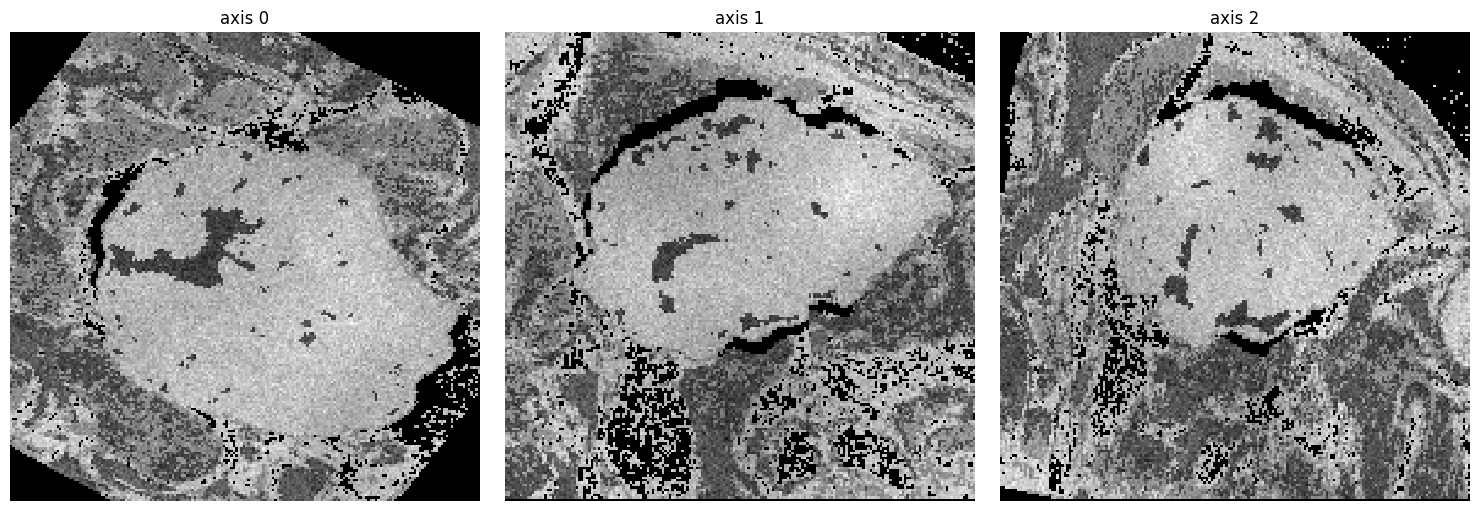

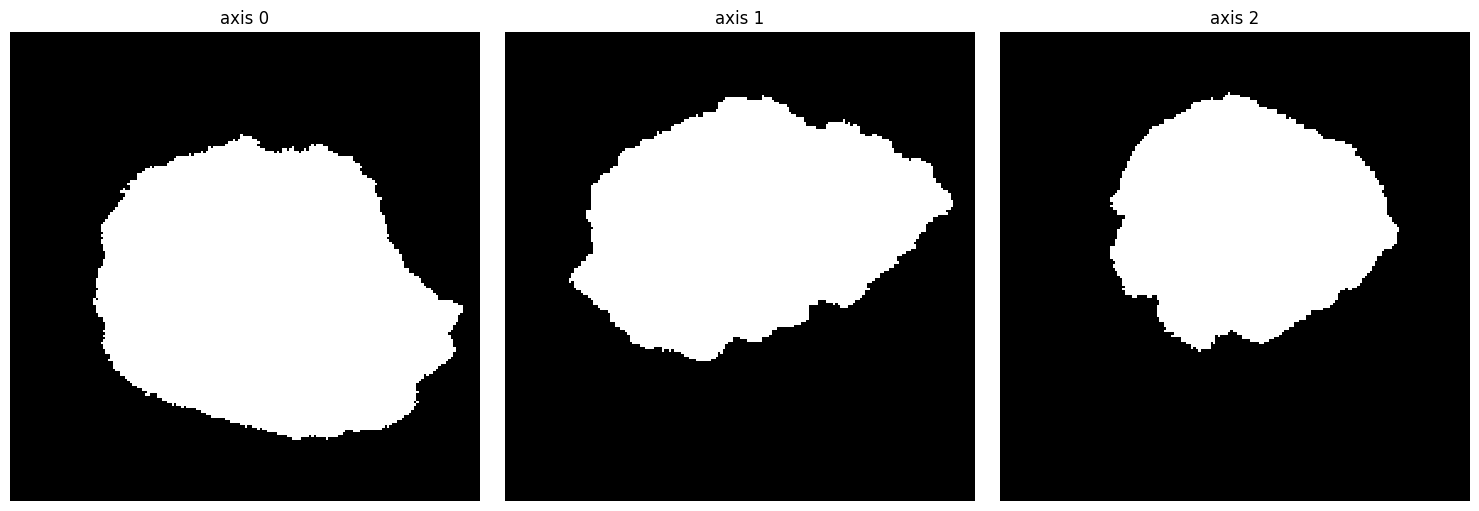

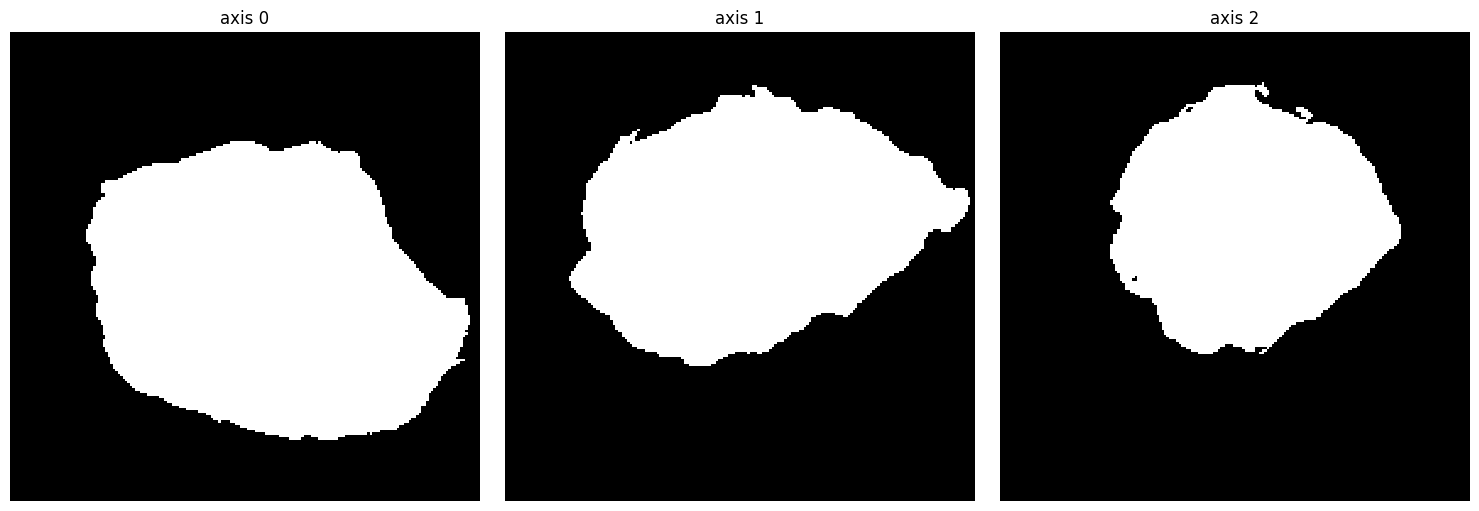

Dice coefficient for synth_data/0_img.nii.gz: 0.9306
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


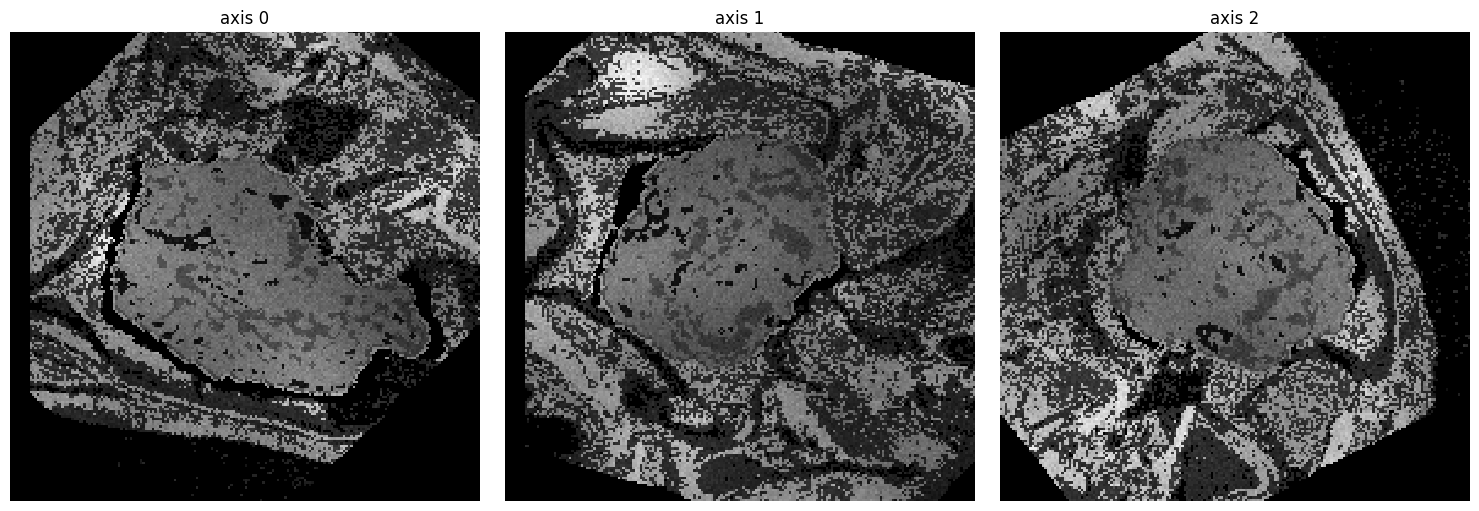

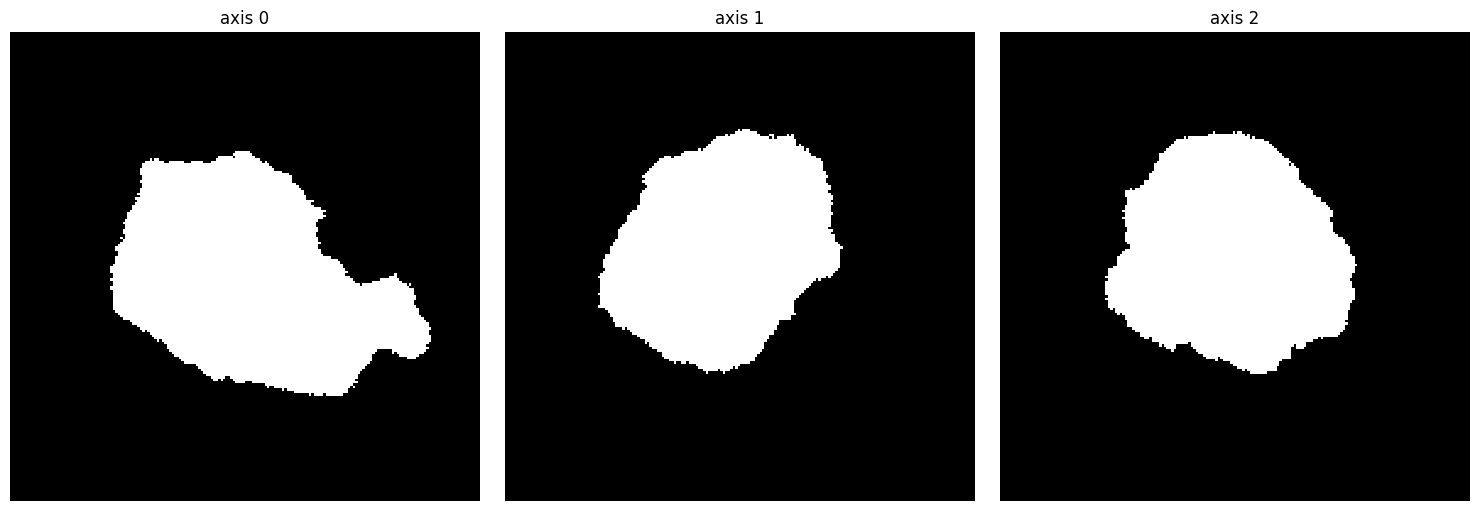

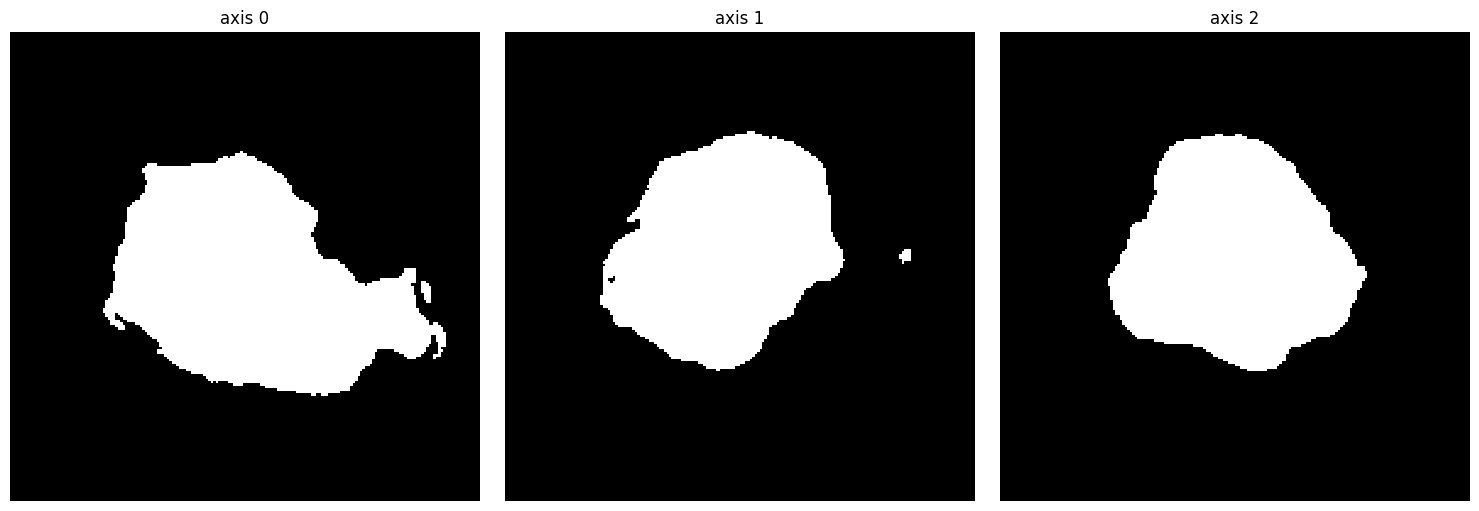

Dice coefficient for synth_data/1_img.nii.gz: 0.9499
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


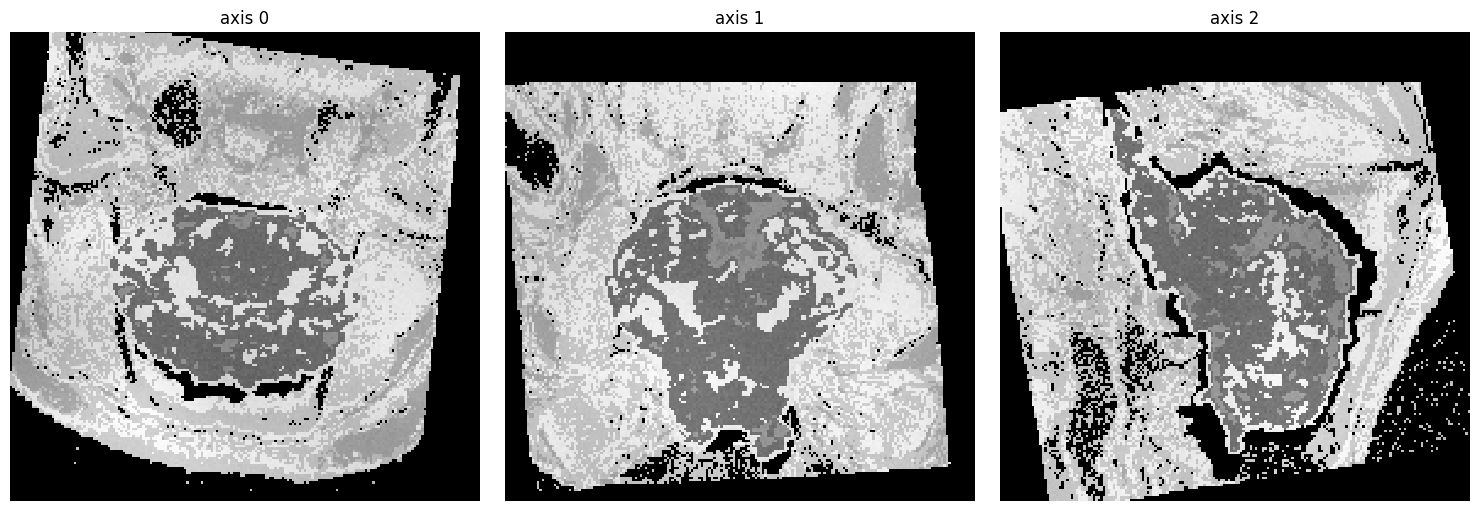

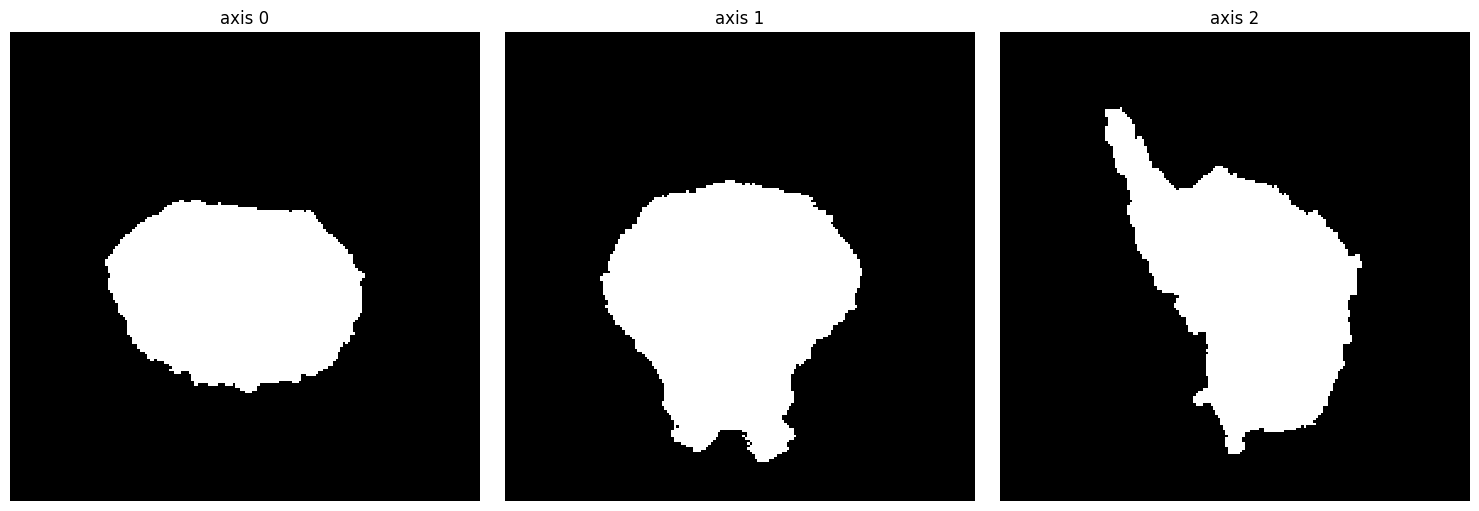

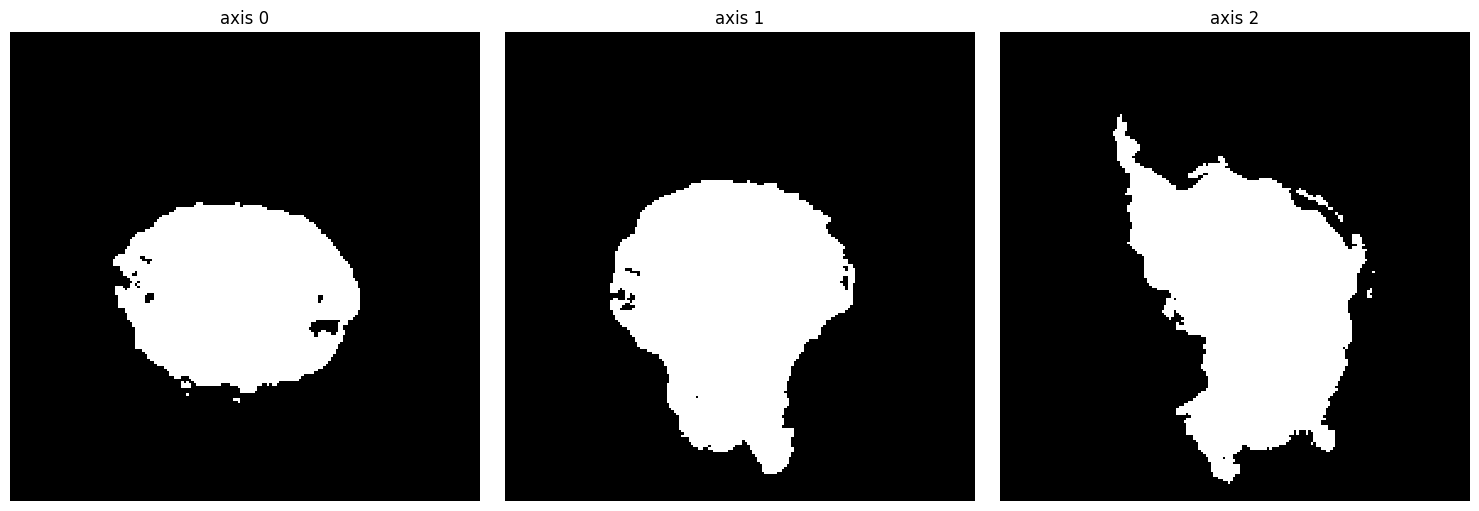

Dice coefficient for synth_data/2_img.nii.gz: 0.9267
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


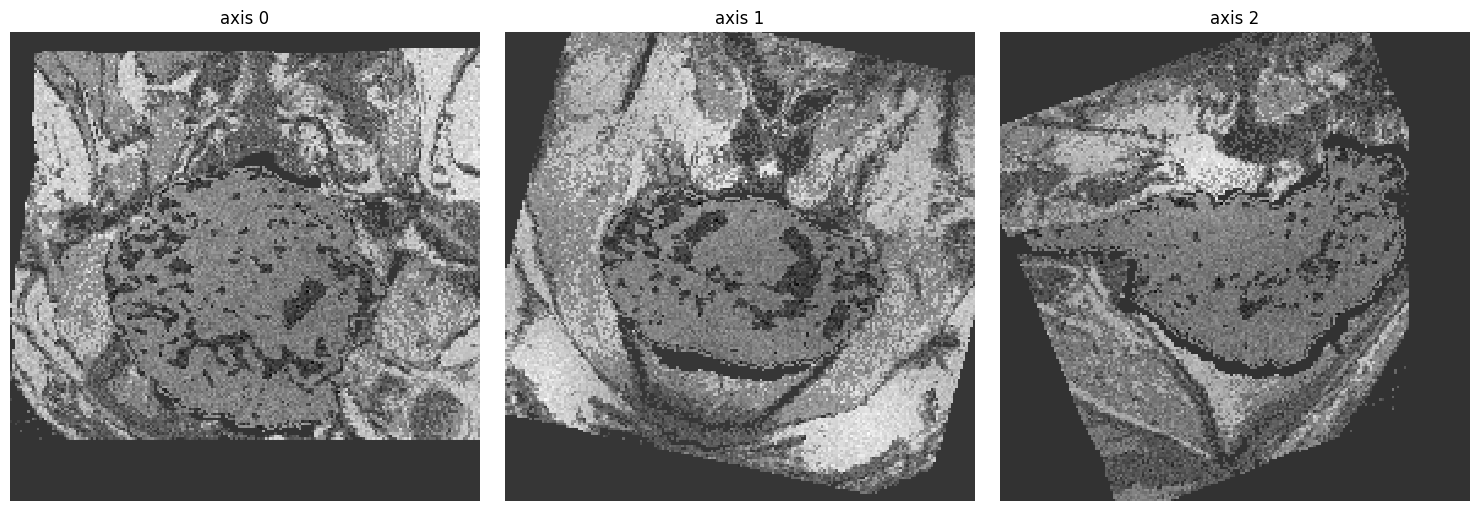

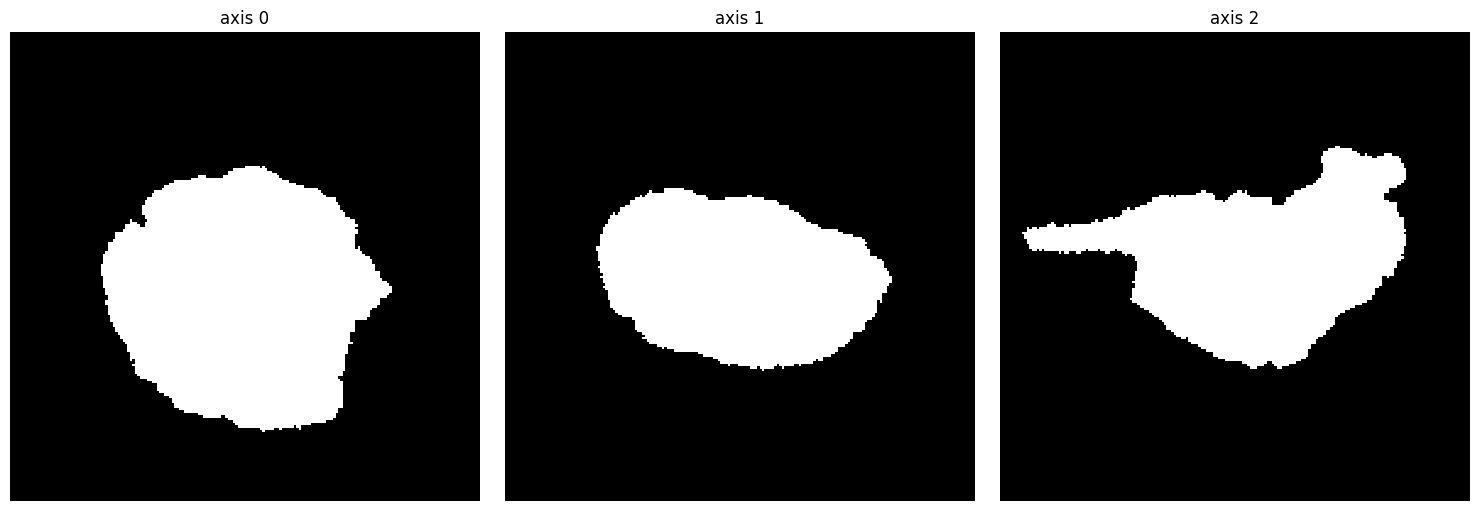

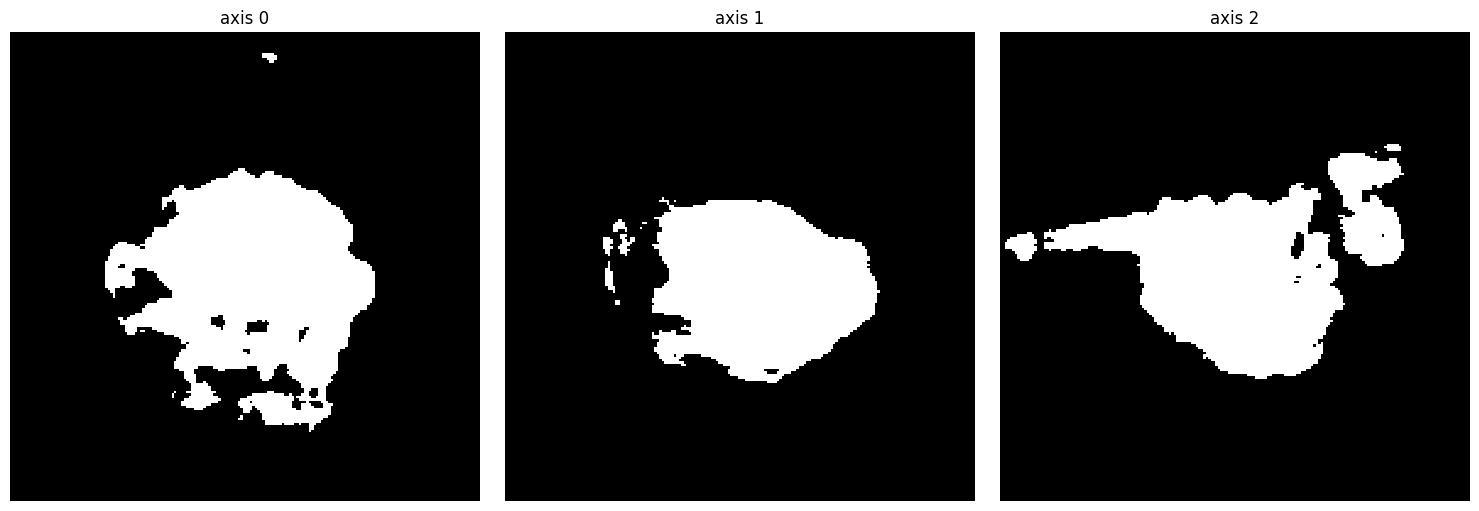

Dice coefficient for synth_data/3_img.nii.gz: 0.8340
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


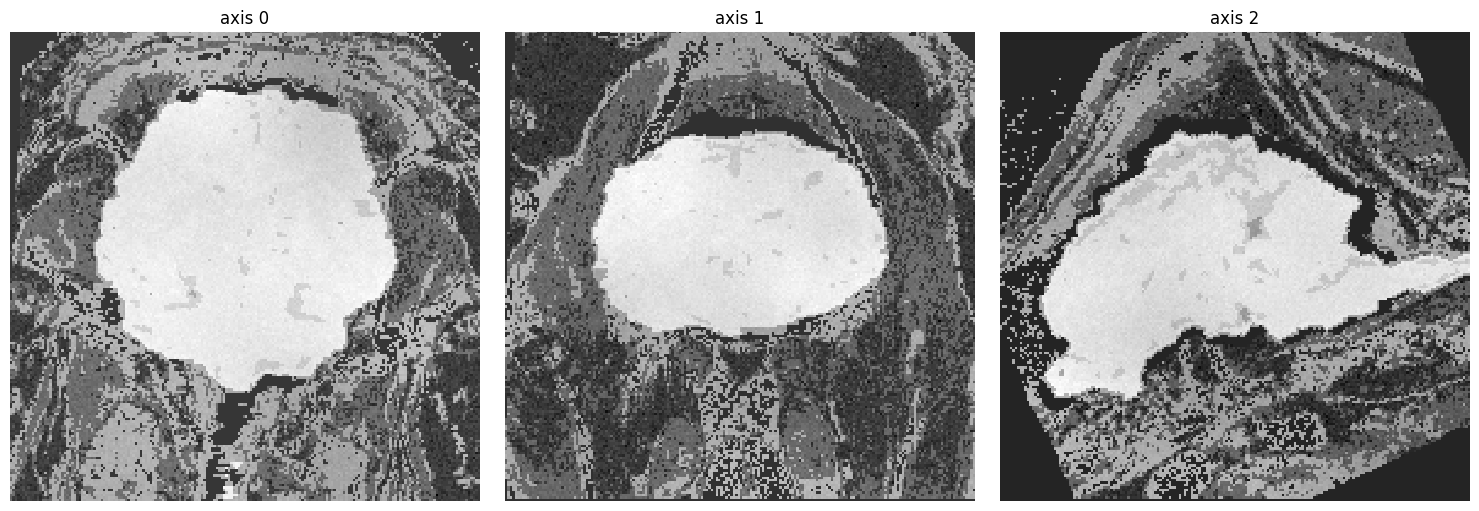

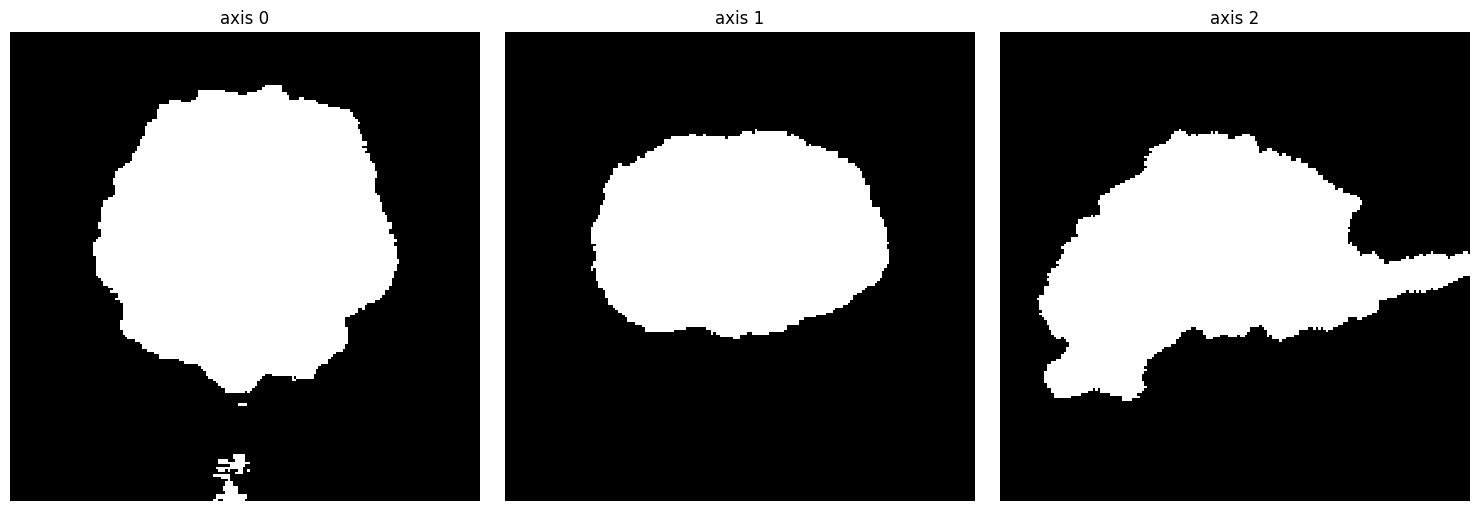

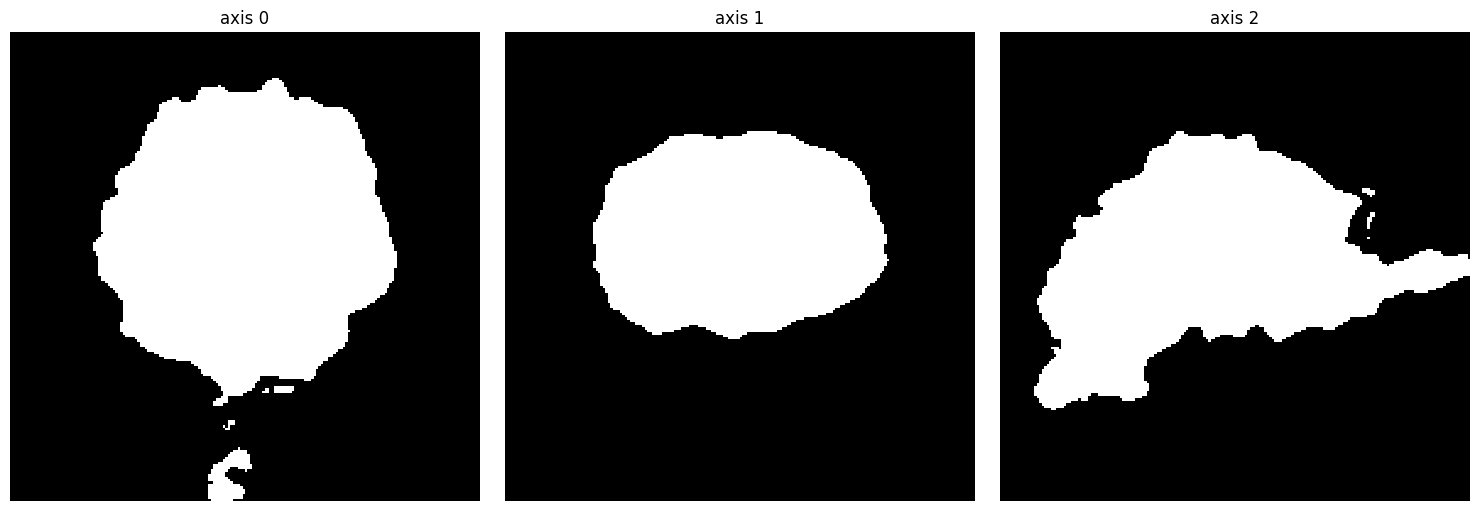

Dice coefficient for synth_data/4_img.nii.gz: 0.9752
Overall Dice coefficient: 0.9233


In [14]:
import os
import numpy as np
import surfa as sf
import neurite as ne
from scipy import ndimage
from sklearn.metrics import jaccard_score

# Store Dice coefficients
dice_scores = []

new_voxsize = [1, 1, 1]

for i in range(5):
    # folder_path = os.path.join(validation_folder_path, folder)
    # folder_name = os.path.basename(folder_path)
        
    filename = os.path.join(validation_folder_path, f"{i}_img.nii.gz")
    mask_filename = os.path.join(validation_folder_path, f"{i}_mask.nii.gz")

    
    # Load mask
    if not os.path.isfile(mask_filename):
        mask = sf.Volume(np.ones((192, 192, 192)))
    else:
        mask = sf.load_volume(mask_filename).resize(new_voxsize, method="linear")
        mask = mask.resize(new_voxsize).reshape([192, 192, 192, 1])

    # Skip if no input file
    if not os.path.isfile(filename):
        continue
        
    # Load and process image
    image = sf.load_volume(filename)
    crop_img = image.resize(new_voxsize, method="linear").reshape([192, 192, 192, 1])

    # Binarize the mask
    mask.data[mask.data != 0] = 1
    


    # Compute mask center
    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    
    # Plot input image and mask
    ne.plot.volume3D(crop_img, slice_nos=ms)
    ne.plot.volume3D(mask, slice_nos=ms)

    # Predict segmentation
    prediction_one_hot = combined_model.predict(crop_img[None, ...], verbose=0)
    prediction = np.argmax(prediction_one_hot, axis=-1)[0]

    # Extract the largest connected component
    labeled, num_components = ndimage.label(prediction > 0)
    largest_mask = labeled == np.argmax(ndimage.sum(prediction > 0, labeled, range(num_components + 1)))
    ne.plot.volume3D(largest_mask, slice_nos=ms)

    # Compute Dice coefficient
    mask_flat = mask.data.flatten()
    prediction_flat = largest_mask.flatten()
    dice_score = 2 * np.sum(mask_flat * prediction_flat) / (np.sum(mask_flat) + np.sum(prediction_flat))
    if np.sum(mask.data)<1000:
        continue
    dice_scores.append(dice_score)

    print(f"Dice coefficient for {filename}: {dice_score:.4f}")
    # break

# Overall Dice coefficient and visualization
overall_dice = np.mean(dice_scores)
print(f"Overall Dice coefficient: {overall_dice:.4f}")




In [6]:
overall_dice

0.33212203610709956

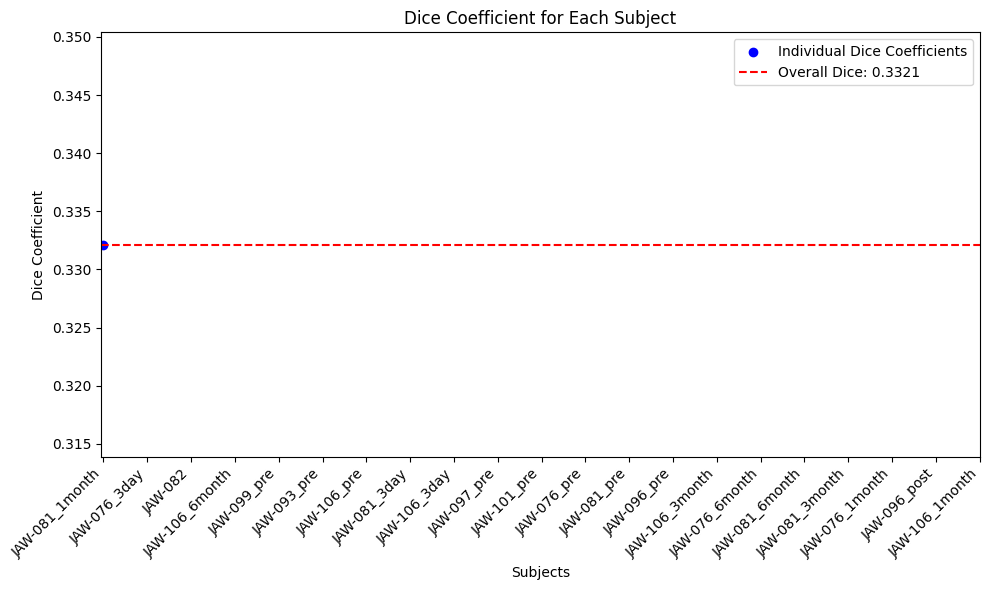

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(dice_scores)), dice_scores, color='blue', label='Individual Dice Coefficients')
plt.axhline(overall_dice, color='red', linestyle='--', label=f'Overall Dice: {overall_dice:.4f}')
plt.xlabel('Subjects')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient for Each Subject')
plt.legend()
plt.xticks(range(len(subfolders)), subfolders, rotation=45, ha='right')
plt.tight_layout()
plt.show()
